In [241]:
import xml.etree.ElementTree as ET
import urllib.request
import csv
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import json
import re
import os


In [345]:
#### Get WIGOS IDs for all stations catalogued in a country ####

country = "KEN"

# API: all stations as json
all_stations_KEN_url = "https://oscar.wmo.int/surface/rest/api/search/station?territoryName="+country


response = urlopen(all_stations_KEN_url)
data_json = json.loads(response.read())
stations = data_json["stationSearchResults"]

wigosIds = []

for station in data_json["stationSearchResults"]:
    # print(station["wigosId"])
    wigosId = str(station["wigosId"])
    wigosIds.append(wigosId)

print(wigosIds)

['0-404-300-301570787AS00074', '0-404-300-402261127AS63663', '0-404-300-271440721AS00049', '0-404-300-281480740AS00057', '0-404-0-63707', '0-404-300-392191090AS63662', '0-404-0-63721', '0-404-300-040200100AS00113', '0-404-300-040200098AS00112', '0-404-300-301620807AS00073', '0-404-300-301580790AS00071', '0-404-300-402251125AS00038', '0-404-300-402281141AS00036', '0-404-300-402291146AS00033', '0-404-300-392181085AS63660', '0-404-300-361950974AS00015', '0-20000-0-63741', '0-404-300-472781389AS63747', '0-404-300-100470235AS00114', '0-404-300-372081037AS00024', '0-404-300-372000999AS00025', '0-404-300-372031019AS00022', '0-404-300-372101048AS00026', '0-20000-0-63688', '0-404-300-63686', '0-20000-0-63720', '0-404-0-63719', '0-404-300-341870932AS00005', '0-404-300-341840918A00001', '0-404-300-050210101AS00090', '0-404-0-63670', '0-20000-0-63723', '0-404-300-190950473AS00101', '0-404-300-060230111AS00047', '0-404-300-190950476AS00099', '0-404-300-070320150AS00107', '0-404-300-341840918AS00001

In [347]:
#### append information to json file ####

def write_json(new_data, filename='data.json'):
    with open(filename,'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        # Join new_data with file_data inside emp_details
        file_data["stations"].append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file, indent = 4)

In [348]:
#### Get station xml Files via jOAI ####


for id in wigosIds[0:2]:

    # get url
    url = "https://oscar.wmo.int/oai/provider?verb=GetRecord&metadataPrefix=wmdr&identifier=%20" + id

    # get xml from url
    document = requests.get(url)
    soup= BeautifulSoup(document.content,"xml")

    #### get information to plot ####

    # Name
    name = soup.find_all('name')
    name = re.findall(r'.*?\>(.*)\<.*',str(name))

    # Location
    location = soup.find_all('pos')
    location = re.findall(r'.*?\>(.*)\<.*',str(location))[0]
    loc = re.findall(r'[0-9]*\.?[0-9]*', location)
    lat = loc[0]
    lon = loc[2]
    ele = loc[4]

    # observed Variables
    observedProperties = soup.find_all('observedProperty')
    observedProperties_notation = re.findall(r'\d+',str(observedProperties))
        
    # begin Position
    beginPosition = soup.find_all('beginPosition')
    beginPosition = re.findall(r'\d{4}-\d{2}-\d{2}',str(beginPosition))[0]
    # print(beginPosition)

    # ReportingStatus
    reportingStatus = soup.find_all('reportingStatus')
    # print(reportingStatus)
    reportingStatus = re.findall(r'http://codes.wmo.int/wmdr/ReportingStatus/(.*)\"\s.*',str(reportingStatus))[0]
    

    #### save to json File ####
    aDict = {"wigosId" : id, "name":name, "lat":lat, "lon":lon, "ele":ele, "observedProperties" : observedProperties_notation, "beginPosition" : beginPosition, "reportingStatus": reportingStatus}
    print(aDict)
    write_json(aDict)
   

{'wigosId': '0-404-300-301570787AS00074', 'name': ['AIC Churo Girls  High School'], 'lat': '0.7668', 'lon': '36.4056', 'ele': '1798.0', 'observedProperties': ['210', '216', '224', '251', '12005', '12006'], 'beginPosition': '2021-11-29', 'reportingStatus': 'operational'}
{'wigosId': '0-404-300-402261127AS63663', 'name': ['ALUPE'], 'lat': '0.497', 'lon': '34.1252', 'ele': '1161.0', 'observedProperties': ['210', '210', '216', '224', '225', '230', '251', '12005', '12006'], 'beginPosition': '2020-09-22', 'reportingStatus': 'operational'}


In [350]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd
import matplotlib.lines as mlines

In [361]:
# Load map background
m = Basemap(projection='lcc', resolution='h', 
            lat_0=0.1, lon_0=37.5,
            width=1.5E6, height=1.2E6)

In [365]:
f = open(os.getcwd()+'/data.json')
data = json.load(f)

for i in data['stations']:
    print(float(i["lat"]))

0.7668
0.497


0.7668
0.497


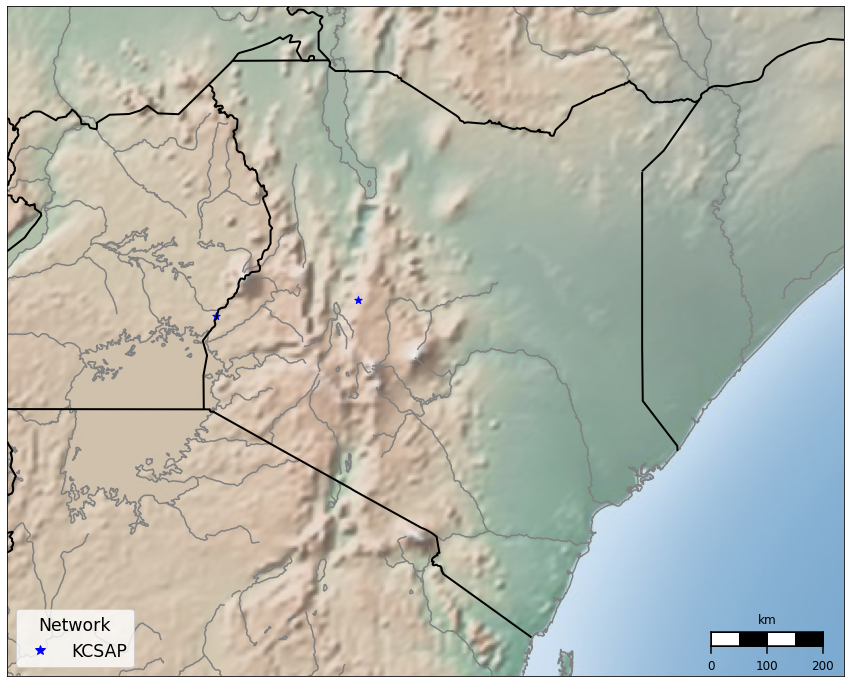

In [366]:
#### DRAW MAP ####

fig = plt.figure(figsize=(15, 15))


# map background
# m.fillcontinents(color='tan',lake_color='lightblue')
m.shadedrelief()
# m.etopo()
# m.bluemarble()
m.drawmapscale(lon=43, lat=-4.7, lon0=43,lat0=-4, length=200, barstyle="fancy", linecolor="black", fillcolor2="black", fontsize=12, fontcolor="black")
m.drawcoastlines(color='grey', linewidth=1.5)
m.drawrivers(color='grey', linewidth=1.5)
m.drawcountries(color='black', linewidth=2)
# m.drawlsmask(land_color='0.8', ocean_color='w', lsmask=None, lsmask_lons=None, lsmask_lats=None, lakes=True, resolution='l', grid=5)
# m.drawmapboundary(color='k', linewidth=1.0, fill_color=None, zorder=None, ax=None)



f = open('data.json')
data = json.load(f)

f = open(os.getcwd()+'/data.json')
data = json.load(f)

for i in data['stations']:
    print(float(i["lat"]))

    lat = float(i["lat"])
    lon = float(i["lon"])
    m.scatter(lon, lat,latlon=True,c="blue",s=60,marker="*")


# legend
stations = mlines.Line2D([], [], color='blue', marker='*', linestyle='None',markersize=10, label='KCSAP')
plt.legend(handles=[stations], loc=3, title="Network", title_fontsize="xx-large", labelcolor="black", fontsize="xx-large")


# save plot
plt.savefig("/home/sdanioth/Documents/git/plot_map/plots/test_plot.pdf", bbox_inches='tight')